**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***


<p align="center">
<img src="media/agents_header.png" alt="LLM" width="800"/> <br>
Image from TrueFoundry's "<i><a href="https://www.truefoundry.com/blog/llm-agents">What are LLM Agents?</a></i>". <br>Copyright © 2025. All rights reserved.
</p>

***
Sources: <br>
- [What are LLM Agents? (TrueFoundry)](https://www.truefoundry.com/blog/llm-agents)
- [What is an AI Agent? (LangChain)](https://blog.langchain.dev/what-is-an-agent/)


# LLM agents

Think about how we have used LLMs so far: We have an LLM a single task. It's easy to consider that we could *chain* these tasks together to create a more complex system. For example, we could ask a language model to generate a summary of a text, and then - in a separate step - ask it to classify the sentiment of the summary. This is what we call *chaining* of LLM tasks. In chains, a sequence of actions is hardcoded (in code). In agents, a language model is used as a *reasoning engine* to determine which actions to take and in which order. In other words, an AI agent is a system that uses an LLM to decide the control flow of an application, instead of having it hardcoded. 

An LLM Agent will

1. Receive a sensory input (e.g. a text)
2. Decide what to do with it
3. Take an action (e.g. generate a summary)

Let's think about the implications of this for a moment. If we can get an LLM to consider a task and then decide for itself how best to solve it, we are approaching a very human-like way of thinking.

### What does it mean to be agentic?

<p align="center">
<img src="media/levels-of-agentic.png" alt="LLM" width="800"/> <br>
Image from LangChain's "<i><a href="https://blog.langchain.dev/what-is-an-agent/">What is an AI agent?</a></i>" by Harrison Chase, CEO of LangChain AI. <br>Copyright © 2025. All rights reserved.
</p>

According to Harisson Chase, a system is more “agentic” the more an LLM decides how the system can behave.

| Level of Agentic Behavior                                                                 | Description                                                                                                                                                     |
|------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Router                                                                                   | Using an LLM to route inputs into a particular downstream workflow has some small amount of “agentic” behavior. This would fall into the `Router` category.       |
| Between Router and State Machine                                                        | If you use multiple LLMs to do multiple routing steps, this would be somewhere between `Router` and `State Machine`.                                                |
| State Machine                                                                            | If one of those steps is determining whether to continue or finish - effectively allowing the system to run in a loop until finished, it would fall into this category. |
| Autonomous Agent                                                                         | If the system is building tools, remembering those, and then taking those in future steps, it is incredibly agentic, similar to what the [Voyager paper](https://arxiv.org/abs/2305.16291) implemented. |

### Agents as graph-based systems

<p align="center">
<img src="media/graph.png" alt="LLM" width="800"/> <br>
Image from Ionio "<i><a href="https://www.ionio.ai/blog/a-comprehensive-guide-about-langgraph-code-included">A Comprehensive Guide About Langgraph</a></i>". <br>by Shivam Danawale and Pranav Patel<br>
Copyright © 2025. All rights reserved.
</p>

Following the image above, we see that the workflow is triggered by an input from a user. Next, we hit the first node, likely an LLM. This LLM provides an output - not back to the user but to the next nodes, routed via *conditional edges*. In other words, we can pick which route we will take to answer the query - or carry out the associated task. We can repeat this process for downstream nodes. Eventually, we will end in an *END* node - or we might even return to the first node again and start over!

***

### Agents in LangGraph

We will be using *LangGraph* to create a simple agent system in this notebook. LangGraph is a graph-based system that allows us to create complex workflows using LLMs. A couple of key concepts in LangGraph are:

| Concept  | Description |
|---------------| ------|
| **State**     | State is the central concept in LangGraph. It represents all the information that flows through your application. |
| **Node**      | A node is a single unit of computation - just like neurons in neural networks. In LangGraph, nodes are Python functions. For example, Nodes can contain LLM calls (Generate text or make decisions), Tool calls (Interact with external systems), Conditional logic (Determine next steps), Human intervention (Get input from users). Some nodes necessary for the whole workflow like START and END exist from LangGraph directly. |
| **Edges**     | Edges connect nodes and define the possible paths through your graph. |
| **StateGraph**| The StateGraph is the container that holds your entire agent workflow. |

LangChain has released an excellent [introduction to these concepts here](https://huggingface.co/learn/agents-course/unit2/langgraph/building_blocks)







### Setup

We will be using *LangGraph* to create a simple agent system. LangGraph is a graph-based system that allows us to create complex workflows using LLMs. 

In [ ]:
# built-in libraries
from typing import TypeVar, Literal, TypedDict,  Any, Optional

# langgraph libraries
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.graph import  MermaidDrawMethod

# litellm libraries
import litellm
from litellm import completion
from instructor import Mode, from_litellm

# misc libraries
from IPython.display import Image
from decouple import config
from pydantic import BaseModel, Field, create_model
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams

Let's start by loading our WatsonX.ai credentials again

In [44]:
WX_API_KEY = config("WX_API_KEY")
WX_PROJECT_ID = config("WX_PROJECT_ID")
WX_API_URL = "https://us-south.ml.cloud.ibm.com"

***

## Using Instructor for LLM interactions

Remember how we used `litellm` and `instructor` to setup our LLM-as-a-judge in part 1: RAG? We will use the same concept here. 

| **Library**   | **Description**   |
|---------------| -|
| **LiteLLM**   | A convenient wrapper to call 100+ LLMs using OpenAI's Input/Output Format. It <br>(1) automatically translates inputs to provider's completion, embedding, and image_generation endpoints, <br>(2) ensures consistent output at `['choices'][0]['message']['content']`, and <br>(3) implements retry/fallback logic across multiple deployments (e.g., Azure/OpenAI). |
| **Instructor**| Makes it easy to get structured data like JSON from LLMs. It enables us to get a `pydantic` model from the response, ensuring that the LLM always outputs the same format. For example, it can provide multiple responses like a category and a reason for its choice. |

Let's try a small examples

In [ ]:
litellm.drop_params = True  # watsonx.ai doesn't support `json_mode`
client = from_litellm(completion, mode=Mode.JSON)  # create a client from litellm

# create a response model
class Response(BaseModel): # <--- BaseModel is a Pydantic class

    # ask the LLM to return a short reasoning - Remember how reasoning can help LLMs?
    reasoning : str = Field(description="The short reasoning behind the answer")
    # ask the LLM to return the answer as a separate field
    answer : str = Field(description="Your answer to the question")


# define a prompt
prompt = """You are a cat expert. Answer the following question about cats:

Q: What is the average lifespan of a cat?

Provide your answer as an object of Response""" # <-- We ask the model to return the answer as an object of Response

# make a request to the LLM
response = client.chat.completions.create(
            model="watsonx/meta-llama/llama-3-3-70b-instruct", # <--- model name from watsonx.ai
            messages=[
                {
                    "role": "user",
                    "content": prompt,  # <- Our prompt
                }
            ],
            project_id=WX_PROJECT_ID, # <- Our credentials
            apikey=WX_API_KEY,
            api_base=WX_API_URL,
            response_model=Response, # <- Inform the LLM of the response model
)

In [46]:
response

Response(reasoning="This is based on various studies and data from veterinary organizations, which suggest that with proper care and nutrition, a domestic cat's average lifespan ranges from 12 to 15 years, depending on factors such as breed, lifestyle, and health conditions", answer='The average lifespan of a cat is around 12-15 years')

In [50]:
print(response.reasoning)

print(response.answer)

This is based on various studies and data from veterinary organizations, which suggest that with proper care and nutrition, a domestic cat's average lifespan ranges from 12 to 15 years, depending on factors such as breed, lifestyle, and health conditions
The average lifespan of a cat is around 12-15 years


Pretty neat, right?

***

But what if we don't want to define response models for every call we make to an LLM? `pydantic` (and therefore `instructor`) supports *dynamic* response models, via the `create_model` function. 

We can use that like shown below. Note that we have to define the type (i.e. str, int, float or bool) of each response field and add a `Field` object as well. The Field object can be used to define default values, add descriptions for the LLM etc. 

In [52]:
response_model = create_model(
    "MyResponseModel", 
    reasoning=(str, Field(description="The short reasoning behind the answer")),
    answer=(str, Field(description="Your answer to the question")),
    __base__=BaseModel
) 

In [54]:
response_model(reasoning="what the LLM would reason about", answer="what the LLM would answer")

MyResponseModel(reasoning='what the LLM would reason about', answer='what the LLM would answer')

To make our life even easier, here is a class - `LLMCaller` that will do everything we just did for us. 

In [55]:
class BaseResponse(BaseModel):
    """A default response model that defines a single 
    field `answer` to store the response from the LLM.
    We will use this when there is no need to create
    a custom response model."""
    answer: str


# Define a type variable for the response model
# this you can ignore for now - it is just for type hinting
ResponseType = TypeVar('ResponseType', bound=BaseModel)


class LLMCaller:
    """ A class to interact with an LLM  using the LiteLLM and Instructor
    libraries. This class is designed to simplify the process of sending
    prompts to an LLM and receiving structured responses. """

    def __init__(self, api_key: str, project_id: str, api_url: str, model_id: str, params: dict[str, Any]):
        """
        Initializes the LLMCaller instance with the necessary credentials and configuration.

        Args:
            api_key (str): The API key for authenticating with the LLM service.
            project_id (str): The project ID associated with the LLM service.
            api_url (str): The base URL for the LLM service API.
            model_id (str): The identifier of the specific LLM model to use.
            params (dict[str, Any]): Additional parameters to configure the LLM's behavior.
        """
        self.api_key = api_key
        self.project_id = project_id
        self.api_url = api_url
        self.model_id = model_id
        self.params = params

        # Boilerplate: Configure LiteLLM to drop unsupported parameters for Watsonx.ai
        litellm.drop_params = True
        # Boilerplate: Create an Instructor client for pydantic-based interactions with the LLM
        self.client = from_litellm(completion, mode=Mode.JSON)

    def create_response_model(self, title: str, fields: dict) -> ResponseType:
        """ Dynamically creates a Pydantic response model for the LLM's output.
        Args:
            title (str): The name of the response model.
            fields (dict): A dictionary defining the fields of the response model.
                           Keys are field names, and values are tuples of (type, Field).

        Returns:
            ResponseType: A dynamically created Pydantic model class.
        """
        return create_model(title, **fields, __base__=BaseResponse)

    def invoke(self, prompt: str, response_model: ResponseType = BaseResponse, **kwargs) -> ResponseType:
        """ Sends a prompt to the LLM and retrieves a structured response.

        Args:
            prompt (str): The input prompt to send to the LLM.
            response_model (ResponseType): The Pydantic model to structure the LLM's response.
                                           Defaults to BaseResponse.
            **kwargs: Additional arguments to pass to the LLM client.

        Returns:
            ResponseType: The structured response from the LLM, parsed into the specified response model.
        """
        response = self.client.chat.completions.create(
            model=self.model_id,
            messages=[
                {
                    "role": "user",
                    "content": prompt + "\n\n" + f"Provide your answer as an object of {type(response_model)}",
                    # notice how we hardcode instructions on the responde model type for the llm
                    # so we don't have to repeat it in the prompt
                }
            ],
            project_id=self.project_id,
            apikey=self.api_key,
            api_base=self.api_url,
            response_model=response_model,
            **kwargs
        )
        return response

In [56]:
model = LLMCaller(
    api_key=WX_API_KEY,  # <- Our credentials
    project_id=WX_PROJECT_ID,
    api_url=WX_API_URL,
    model_id="watsonx/meta-llama/llama-3-3-70b-instruct",  # <- model name from watsonx.ai
    params={GenParams.MAX_NEW_TOKENS: 100}  # <- additional parameters for the LLM
)

In [ ]:
model.invoke("What is a good name for a bee?")  # call with no response model

BaseResponse(answer='A good name for a bee could be Buzz or Honey.')

In [58]:
response = model.invoke(
    prompt="What is a good name for a bee? Think carefully.", 
    response_model=model.create_response_model(  # create a response model dynamically
        "BeeName", 
        {
            "reasoning": (str, Field(...)),
            "bee_name": (str, Field
                (
                    ...,
                    description="The name of the bee."
                )
            )
        }
    )
)

print(response.answer)
print(response.reasoning)

A good name for a bee could be Buzzina
The name Buzzina is a play on the word 'buzz', which is the sound bees make when they fly. It's a cute and memorable name that suits a busy and energetic bee


***

# A simple AI agent

We will build a simple AI agent system: A chatbot - Alfred, the butler, who

1. Reads incoming emails
2. Classifies them into a list of categories
3. Decides whether they are spam or not
4. If they are not spam, he will draft a suitable response
5. If they are spam, he will move the email to the spam folder. 

First, we need to define our `State`. To reiterate, this is the central concept in LangGraph and represents all the information that flows through our application.

All these attributes will be populated as we run the agent system.

In [ ]:
class EmailState(TypedDict):
    # The email being processed
    email: dict[str, Any]  # Contains subject, sender, body, etc.

    # Category of the email
    email_category: Optional[str]  # Category of the email (e.g., work, personal, etc.

    # reason of spam
    spam_reason: Optional[str]  # Reason for categorizing the email as spam
    
    # Analysis and decisions
    is_spam: Optional[bool]  # Whether the email is deemed to be spam or not
    
    # Response generation
    draft: Optional[str]  # Draft response to the email

Now let's define our *nodes* - the python functions that make up the system.

In [61]:
# Initialize our LLM
def read_email(state: EmailState):
    """Alfred reads and logs the incoming email"""
    email = state["email"]  # Extract the email from the state
    
    # Here we might do some initial preprocessing
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    
    # No state changes needed here
    return {} # <- if we don't need to update the state, we return an empty dictionary

def classify_email(state: EmailState):
    """Alfred uses an LLM to determine if the email is spam or legitimate"""
    email = state["email"]  # Extract the email from the state
    
    # Prepare our prompt for the LLM
    prompt = f"""
    As Alfred the butler, analyze this email and determine if it is spam or legitimate.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    First, determine if this email is spam. If it is spam, explain why.
    If it is legitimate, categorize it (inquiry, complaint, thank you, etc.).
    """
    
    # Create our response model
    response_model = model.create_response_model(
        "EmailAnalysis", 
        {
            "spam_reason": (str, Field(description="The reasoning behind the decision.")),
            "is_spam": (Literal["spam", "not spam"], Field(description="Whether the email is spam.")),
            "email_category": (str, Field(description="The category of the email.")) 
        }
    )

    # Call the LLM
    response = model.invoke(prompt, response_model=response_model)

    # Extract the response data
    is_spam = response.is_spam
    spam_reason = response.spam_reason
    email_category = response.email_category
    
    # Return state updates
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
    }

def handle_spam(state: EmailState):
    """Alfred discards spam email with a note"""
    print(f"Alfred has marked the email as spam. Reason: {state['spam_reason']}")
    print("The email has been moved to the spam folder.")
    
    # We're done processing this email
    return {}

def draft_response(state: EmailState):
    """Alfred drafts a preliminary response for legitimate emails"""
    email = state["email"]  # Extract the email from the state
    category = state["email_category"] or "general"  # Default to a general category if not specified
    
    # Prepare our prompt for the LLM
    prompt = f"""
    As Alfred the butler, draft a polite preliminary response to this email.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    This email has been categorized as: {category}
    
    Draft a brief, professional response that Mr. Hugg can review and personalize before sending.
    """
    
    # Call the LLM - this time without a custom response model
    response = model.invoke(prompt) # we can use the default response model here
    answer = response.answer  # Extract the response from the LLM

    # Return state updates
    return {"draft": answer}  # add the draft response to the state

def notify_mr_hugg(state: EmailState):
    """Alfred notifies Mr. Hugg about the email and presents the draft response"""
    email = state["email"]  # Extract the email from the state
    
    # some pretty printing to emulate the notification
    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print(f"Category: {state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["draft"])
    print("="*50 + "\n")
    
    # We're done processing this email
    return {}

Next, let's create our *conditional edge* - the logic that decides which path to take based on the output of the LLM.

In [ ]:
def route_email(state: EmailState) -> str:
    """Determine the next step based on spam classification"""
    if state["is_spam"] == "spam": # If the email is spam
        return "spam" # Move to the spam handling step
    else:
        return "legitimate"  # Move to the legitimate email handling step

Now we have our `State` and our `nodes`, we need our edges - the connections between the nodes that define the possible paths through our graph.

First, we can create our `StateGraph` - the container that holds our entire agent workflow. Then we add nodes and edges to it.

In [62]:
# Create the graph
email_graph = StateGraph(EmailState)  # Initialize the graph with the EmailState state

# Add nodes
email_graph.add_node("read_email", read_email)  # Add the read_email node
email_graph.add_node("classify_email", classify_email)  # Add the classify_email node
email_graph.add_node("handle_spam", handle_spam)  # Add the handle_spam node
email_graph.add_node("draft_response", draft_response)  # Add the draft_response node
email_graph.add_node("notify_mr_hugg", notify_mr_hugg)  # Add the notify_mr_hugg node

# Start the edges - LangGraph requires a start node
email_graph.add_edge(START, "read_email")  # Start with reading the email
# Add edges - defining the flow
email_graph.add_edge("read_email", "classify_email")  # After reading, classify the email

# Add conditional branching from classify_email
email_graph.add_conditional_edges(
    "classify_email",
    route_email, # based on this function..
    {
        "spam": "handle_spam",  # .. we route to these nodes
        "legitimate": "draft_response"
    }
)

# Add the final edges
email_graph.add_edge("handle_spam", END)  # End the process after handling spam
email_graph.add_edge("draft_response", "notify_mr_hugg")  # if not spam, we draft a response..
email_graph.add_edge("notify_mr_hugg", END) # .. and notify Mr. Hugg - END

# Compile the graph
compiled_graph = email_graph.compile()  # Compile the graph

Visualize our graph

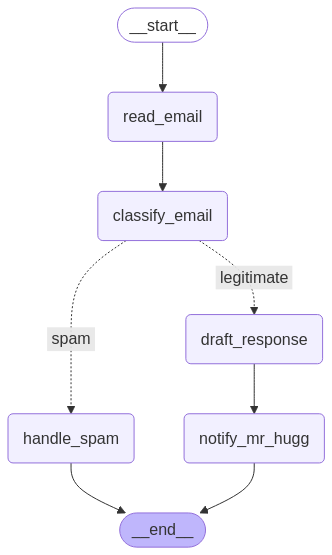

In [74]:
Image(
    compiled_graph.get_graph().draw_mermaid_png(
        draw_method=MermaidDrawMethod.API,
    )
)


## Test our system

In [65]:
# Example legitimate email
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Mr. Hugg, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}

# Example spam email
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

In [66]:

# Process the legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({ # invoke the graph with the email
    "email": legitimate_email,
    "is_spam": None,  # initialize the state variables to None / empty
    "spam_reason": None,
    "email_category": None,
    "draft_response": None,
})

# Process the spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "draft_response": None,
})


Processing legitimate email...
Alfred is processing an email from john.smith@example.com with subject: Question about your services

Sir, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: inquiry

I've prepared a draft response for your review:
--------------------------------------------------
Dear Mr. Smith, Thank you for your email and for considering my consulting services. I'd be delighted to schedule a call with you next week to discuss how I can assist you. Please let me know a few dates and times that work for you, and I'll do my best to accommodate them. I look forward to speaking with you soon. Best regards, Mr. Hugg


Processing spam email...
Alfred is processing an email from winner@lottery-intl.com with subject: YOU HAVE WON $5,000,000!!!
Alfred has marked the email as spam. Reason: The email is attempting to deceive the recipient into sending sensitive financial information and paying a processing fee in exchange for a 